Epoch 10/50, Loss: 901.7450
Epoch 20/50, Loss: 839.5439
Epoch 30/50, Loss: 749.8362
Epoch 40/50, Loss: 678.2125
Epoch 50/50, Loss: 626.3893


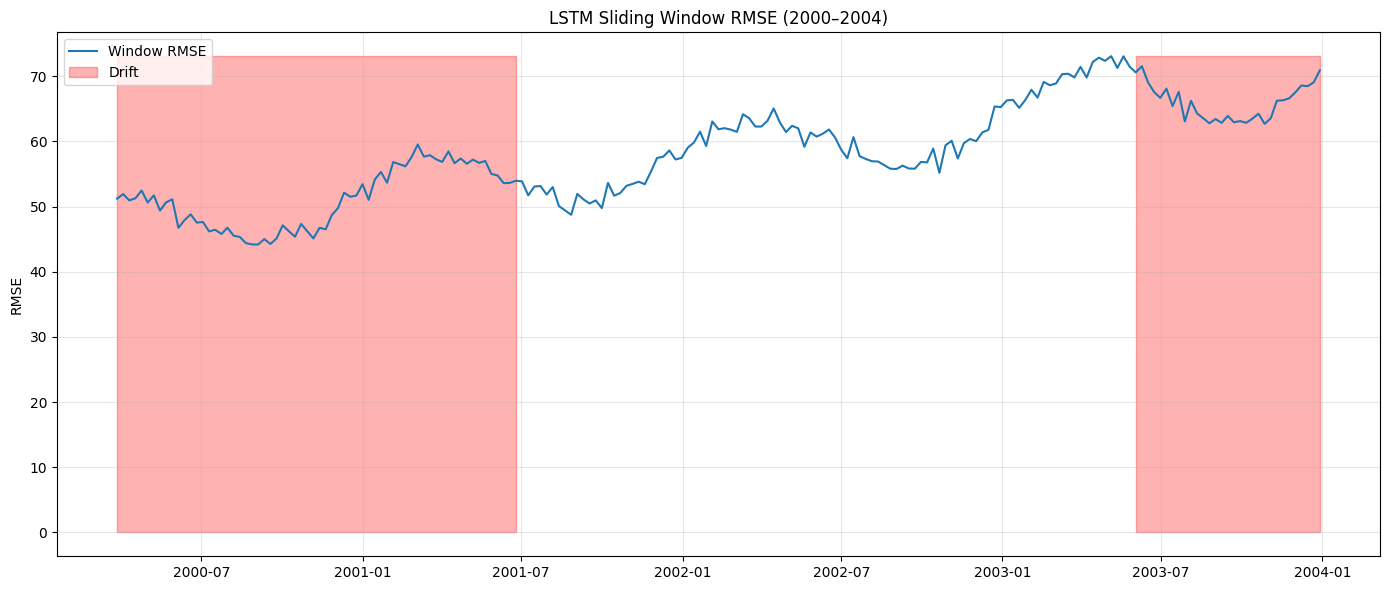

Stable RMSE: 60.220
Drift RMSE: 55.834
Robustness Ratio (Drift/Stable): 0.927


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df = pd.read_csv('../Data/SynData.csv', parse_dates=['date'], index_col='date')


df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)


target = 'var1'
features = [col for col in df.columns if col not in [target, 'drift_period']]
X_all = df[features]
y_all = df[target]

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)


train_df = df['1990':'2000']
inference_df = df['2000':'2010']
X_train = X_all[df.index < '2000']
y_train = y_all[df.index < '2000']

def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

SEQ_LEN = 12  

X_seq_train, y_seq_train = create_sequences(
    X_all_scaled[:len(X_train)], y_train.values, SEQ_LEN
)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out).squeeze()

input_size = X_seq_train.shape[2]
model = LSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_seq_train)
    loss = criterion(y_pred, y_seq_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")


window_size = 12
step = 1

inference_mask = (df.index >= '2000') & (df.index <= '2004')
X_infer = X_all_scaled[inference_mask]
y_infer = y_all[inference_mask]
drift_flags = df.loc[inference_mask, 'drift_period'].values
dates = df.loc[inference_mask].index

results = []


for i in range(0, len(X_infer) - window_size):
    x_window = torch.tensor(X_infer[i:i+window_size], dtype=torch.float32).unsqueeze(0)
    y_true = y_infer.iloc[i+window_size]
    y_pred = model(x_window).item()
    error = (y_pred - y_true) ** 2
    is_drift = int(drift_flags[i+window_size] > 0.5)
    results.append({
        'date': dates[i+window_size],
        'rmse': np.sqrt(error),
        'is_drift': is_drift
    })

results_df = pd.DataFrame(results).set_index('date')

plt.figure(figsize=(14, 6))
plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                 where=results_df['is_drift'] == 1, alpha=0.3, color='red', label='Drift')
plt.title("LSTM Sliding Window RMSE (2000–2004)")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()
stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
robustness = drift_rmse / stable_rmse

print(f"Stable RMSE: {stable_rmse:.3f}")
print(f"Drift RMSE: {drift_rmse:.3f}")
print(f"Robustness Ratio (Drift/Stable): {robustness:.3f}")


Epoch 10, Loss: 2143.8289
Epoch 20, Loss: 2084.9695
Epoch 30, Loss: 1972.5784
Epoch 40, Loss: 1826.5988
Epoch 50, Loss: 1700.0491


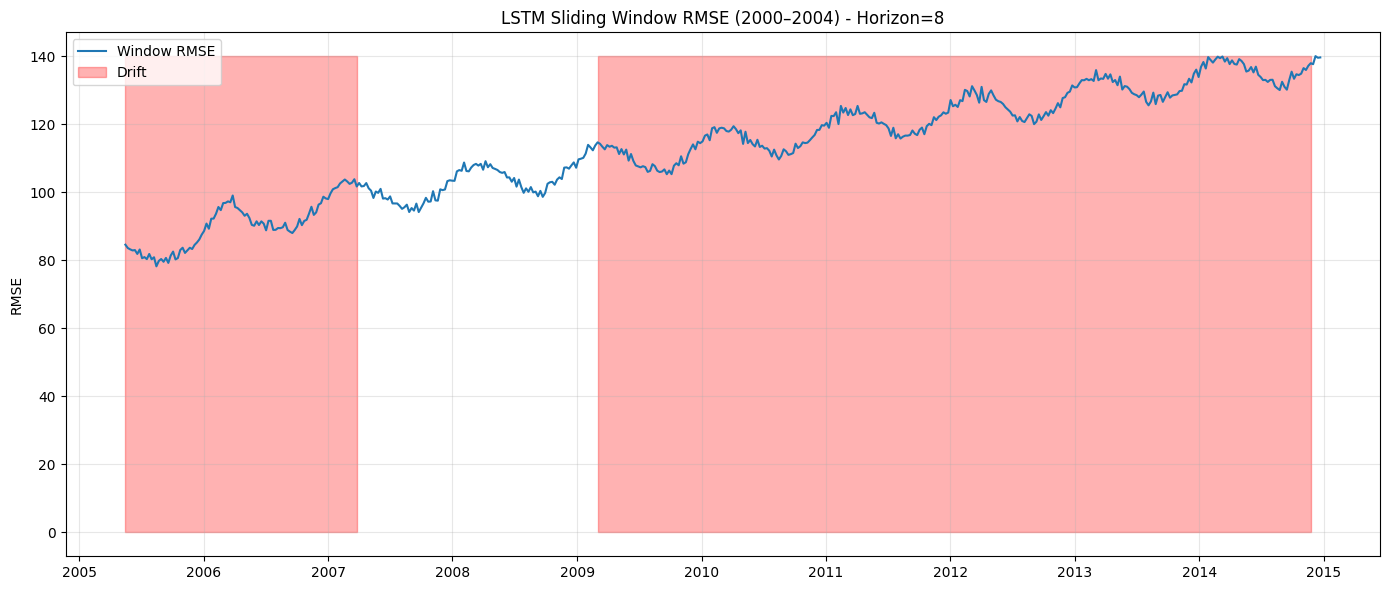

Stable RMSE: 104.276
Drift RMSE: 115.164
Robustness Ratio (Drift/Stable): 1.104


In [8]:
# Extended LSTM drift stress test with multi-step forecasting and no retraining per window
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# === Load & preprocess ===
df = pd.read_csv('../Data/SynData.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

target = 'var1'
features = [col for col in df.columns if col not in [target, 'drift_period']]
X_all = df[features]
y_all = df[target]

scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# === Train on 1990–1999, fixed model ===
train_mask = (df.index >= '1990') & (df.index < '2005')
X_train = X_all_scaled[train_mask]
y_train = y_all[train_mask].values

# === Multi-step target ===
def create_multistep_sequences(X, y, seq_len, horizon):
    xs, ys = [], []
    for i in range(len(X) - seq_len - horizon):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len + horizon - 1])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

SEQ_LEN = 12
HORIZON = 8
X_seq_train, y_seq_train = create_multistep_sequences(X_train, y_train, SEQ_LEN, HORIZON)

# === LSTM model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

model = LSTMModel(X_seq_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_seq_train)
    loss = criterion(y_pred, y_seq_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# === Inference: Fixed model over sliding windows ===
infer_mask = (df.index >= '2005') & (df.index <= '2015')
X_infer = X_all_scaled[infer_mask]
y_infer = y_all[infer_mask].values
drift_flags = df.loc[infer_mask, 'drift_period'].values
dates = df.loc[infer_mask].index

results = []

for i in range(len(X_infer) - SEQ_LEN - HORIZON):
    x_window = torch.tensor(X_infer[i:i+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
    y_true = y_infer[i+SEQ_LEN + HORIZON - 1]
    y_pred = model(x_window).item()
    rmse = np.sqrt((y_pred - y_true) ** 2)
    is_drift = int(drift_flags[i+SEQ_LEN + HORIZON - 1] > 0.5)

    results.append({
        'date': dates[i+SEQ_LEN + HORIZON - 1],
        'rmse': rmse,
        'is_drift': is_drift
    })

results_df = pd.DataFrame(results).set_index('date')

plt.figure(figsize=(14, 6))
plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                 where=results_df['is_drift'] == 1, alpha=0.3, color='red', label='Drift')
plt.title(f"LSTM Sliding Window RMSE (2000–2004) - Horizon={HORIZON}")
plt.ylabel("RMSE")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()
stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
robustness = drift_rmse / stable_rmse

print(f"Stable RMSE: {stable_rmse:.3f}")
print(f"Drift RMSE: {drift_rmse:.3f}")
print(f"Robustness Ratio (Drift/Stable): {robustness:.3f}")



===== Test 1: Stable → Drift =====
Epoch 10, Loss: 19.9473
Epoch 20, Loss: 16.3503
Epoch 30, Loss: 14.9241
Epoch 40, Loss: 12.8402
Epoch 50, Loss: 9.1487


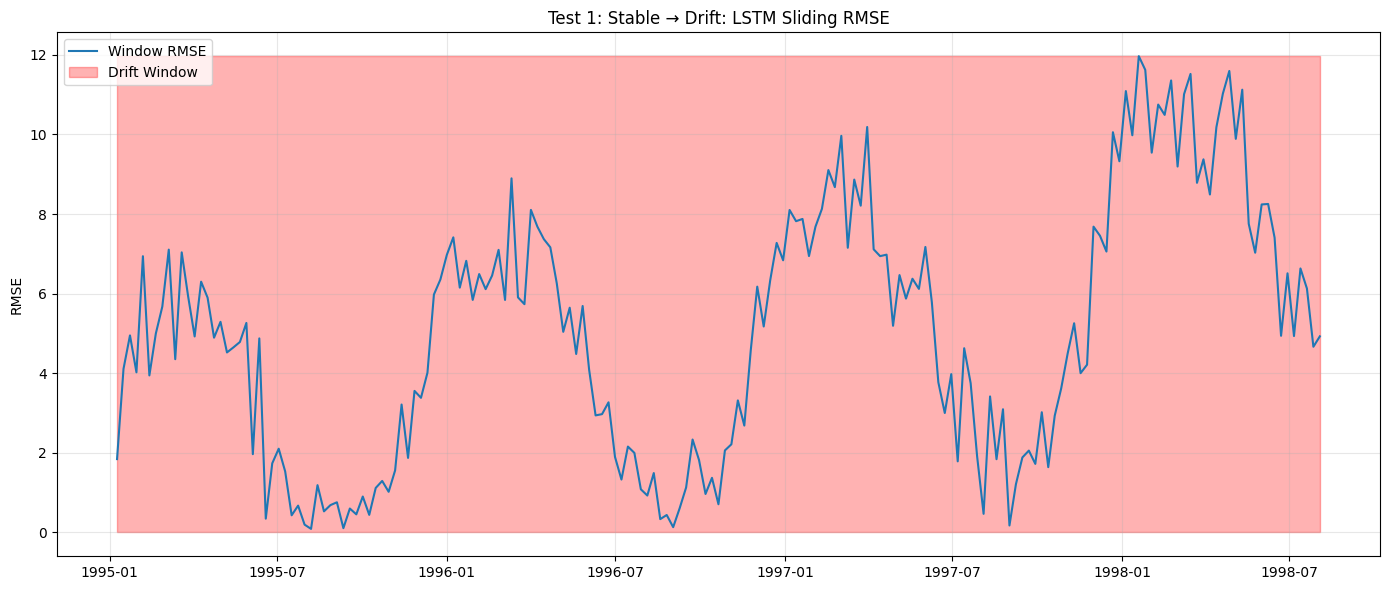

Stable RMSE: nan
Drift RMSE: 5.043
Robustness Ratio (Drift/Stable): nan

===== Test 2: Balanced Mix =====
Epoch 10, Loss: 182.2661
Epoch 20, Loss: 162.4888
Epoch 30, Loss: 122.1274
Epoch 40, Loss: 95.6849
Epoch 50, Loss: 78.9537


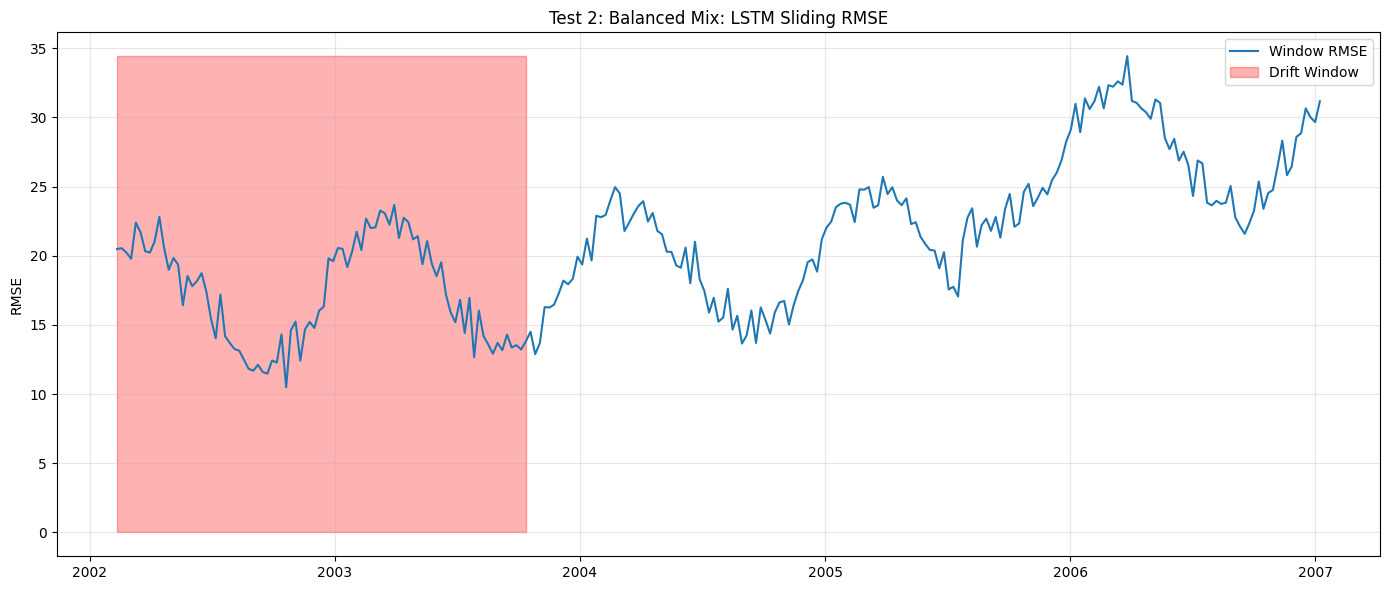

Stable RMSE: 22.938
Drift RMSE: 17.337
Robustness Ratio (Drift/Stable): 0.756

===== Test 3: Long Train, Short Inference =====
Epoch 10, Loss: 276.4132
Epoch 20, Loss: 258.7587
Epoch 30, Loss: 217.0794
Epoch 40, Loss: 175.1923
Epoch 50, Loss: 150.2748


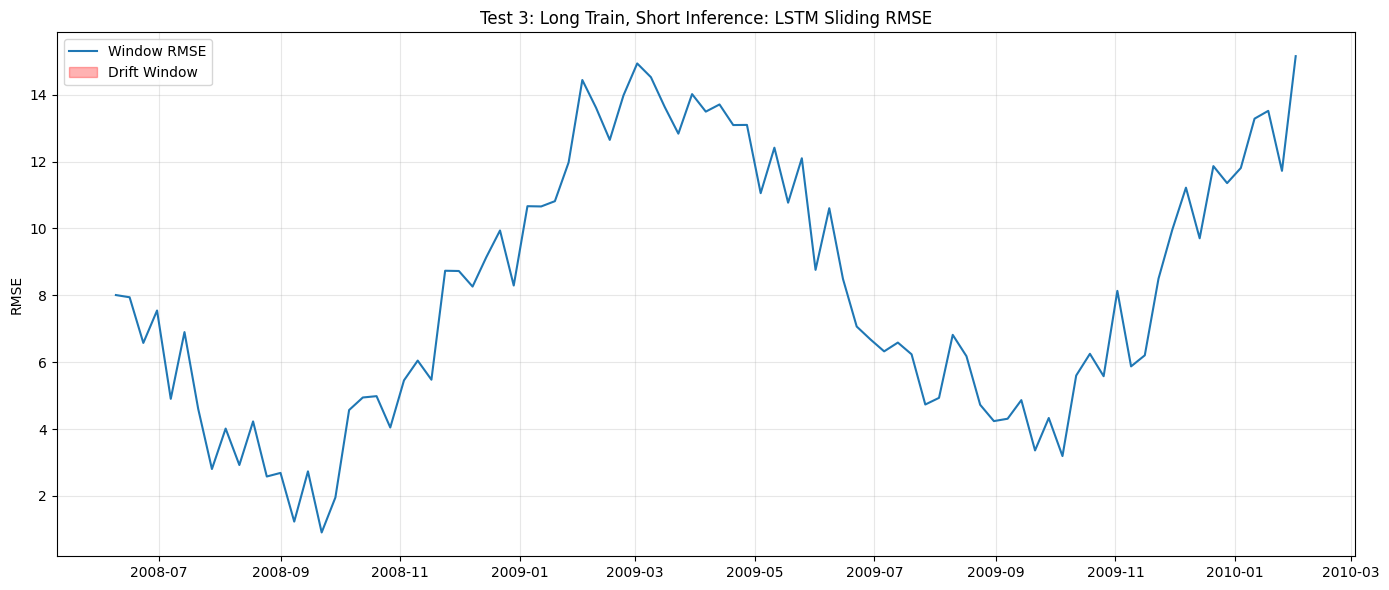

Stable RMSE: 8.137
Drift RMSE: nan
Robustness Ratio (Drift/Stable): nan

===== Test 4: Stable Only → Long Drift =====
Epoch 10, Loss: 272.1771
Epoch 20, Loss: 258.3120
Epoch 30, Loss: 221.1110
Epoch 40, Loss: 174.9484
Epoch 50, Loss: 146.8715


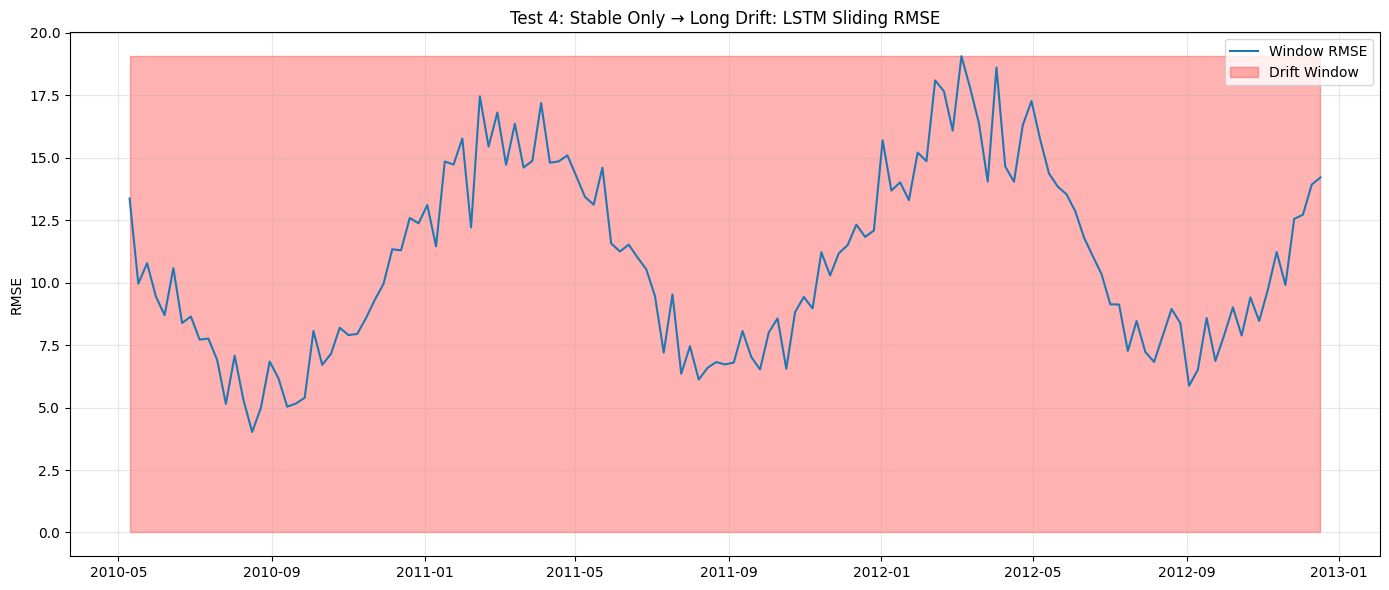

Stable RMSE: nan
Drift RMSE: 10.867
Robustness Ratio (Drift/Stable): nan

===== Test 5: Rolling Regimes =====
Epoch 10, Loss: 268.5190
Epoch 20, Loss: 248.7904
Epoch 30, Loss: 205.4412
Epoch 40, Loss: 167.3135
Epoch 50, Loss: 144.0026


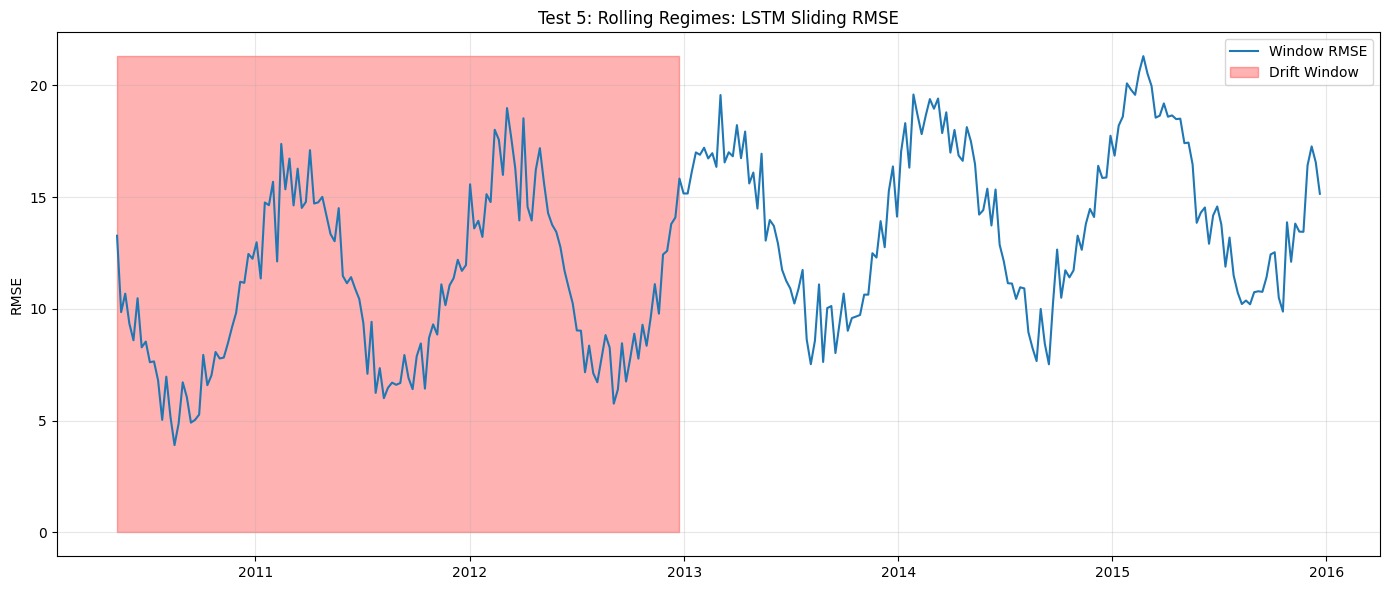

Stable RMSE: 14.262
Drift RMSE: 10.795
Robustness Ratio (Drift/Stable): 0.757


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# === Load & Prepare Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# === Sequence Prep ===
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# === Test Runner ===
def run_lstm_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]

    # Standardize features
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values

    df['scaled_idx'] = np.arange(len(df))

    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_indices = df[train_mask]['scaled_idx'].astype(int).values
    infer_indices = df[infer_mask]['scaled_idx'].astype(int).values

    X_train = X_all[train_indices]
    y_train = y_all[train_indices]

    SEQ_LEN = 12

    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = LSTMModel(X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train)
        loss = criterion(y_pred, y_seq_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # === Inference ===
    results = []
    for idx in range(infer_indices[0], infer_indices[-1] - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        rmse = np.sqrt((y_pred - y_true) ** 2)
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]

        results.append({
            'date': date,
            'rmse': rmse,
            'is_drift': drift_flag
        })

    results_df = pd.DataFrame(results).set_index('date')

    # === Plot RMSE ===
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Window')
    plt.title(f'{test_name}: LSTM Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Aggregate Metrics ===
    mean_rmse_drift = results_df[results_df['is_drift'] == 1]['rmse'].mean()
    mean_rmse_stable = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    robustness_ratio = mean_rmse_drift / mean_rmse_stable

    print(f"Stable RMSE: {mean_rmse_stable:.3f}")
    print(f"Drift RMSE: {mean_rmse_drift:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

# === Run 5 Tests ===
run_lstm_test("Test 1: Stable → Drift",
         "1990-01-01", "1994-10-10",         # stable block 1
         "1994-10-17", "1998-08-10")         # drift block 1

run_lstm_test("Test 2: Balanced Mix",
         "1994-10-17", "2001-11-12",         # drift block 1 + stable block 2
         "2001-11-19", "2007-01-15")         # drift block 2 + stable block 3

run_lstm_test("Test 3: Long Train, Short Inference",
         "1990-01-01", "2008-03-10",         # all data until end of drift block 3
         "2008-03-17", "2010-02-08")         # stable block 4

run_lstm_test("Test 4: Stable Only → Long Drift",
         "1990-01-01", "2010-02-08",         # all stable blocks up to stable block 4
         "2010-02-15", "2012-12-24")         # drift block 4

run_lstm_test("Test 5: Rolling Regimes",
         "1990-01-01", "2010-02-08",         # mixed training
         "2010-02-15", "2015-12-28")         # drift block 4 + stable block 5



===== Test 1: Stable → Drift =====


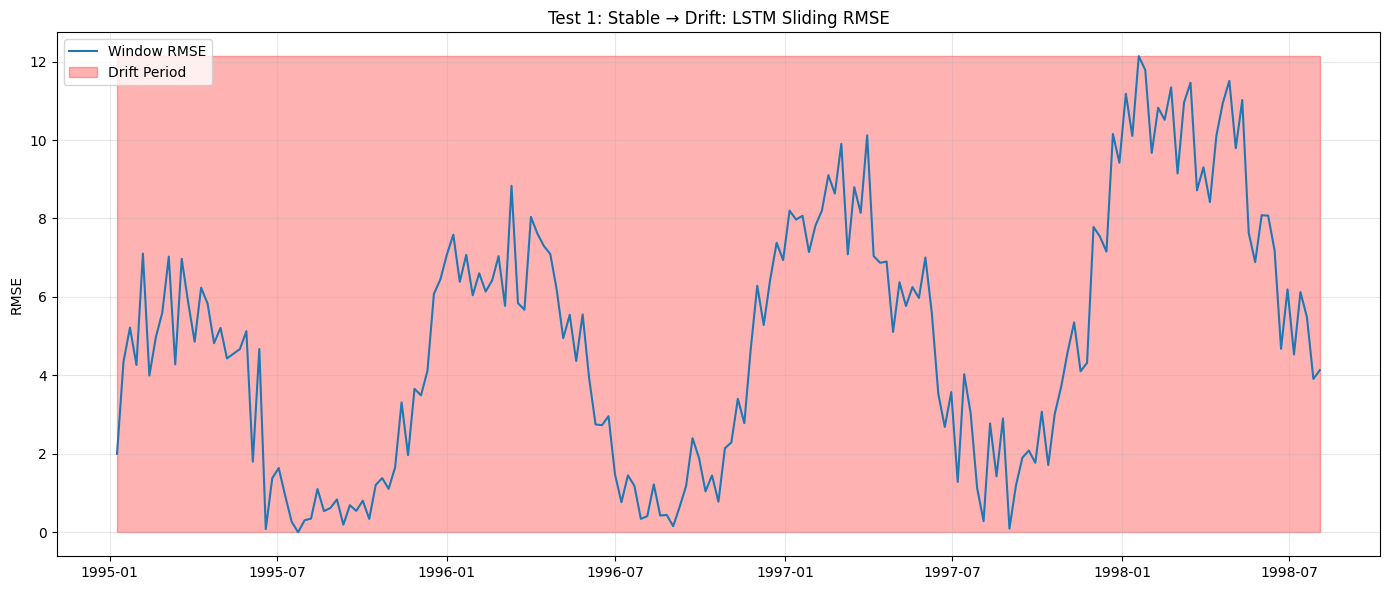

Stable RMSE: 0.999
Drift RMSE: 4.969
Robustness Ratio (Drift/Stable): 4.973

===== Test 2: Balanced Mix =====


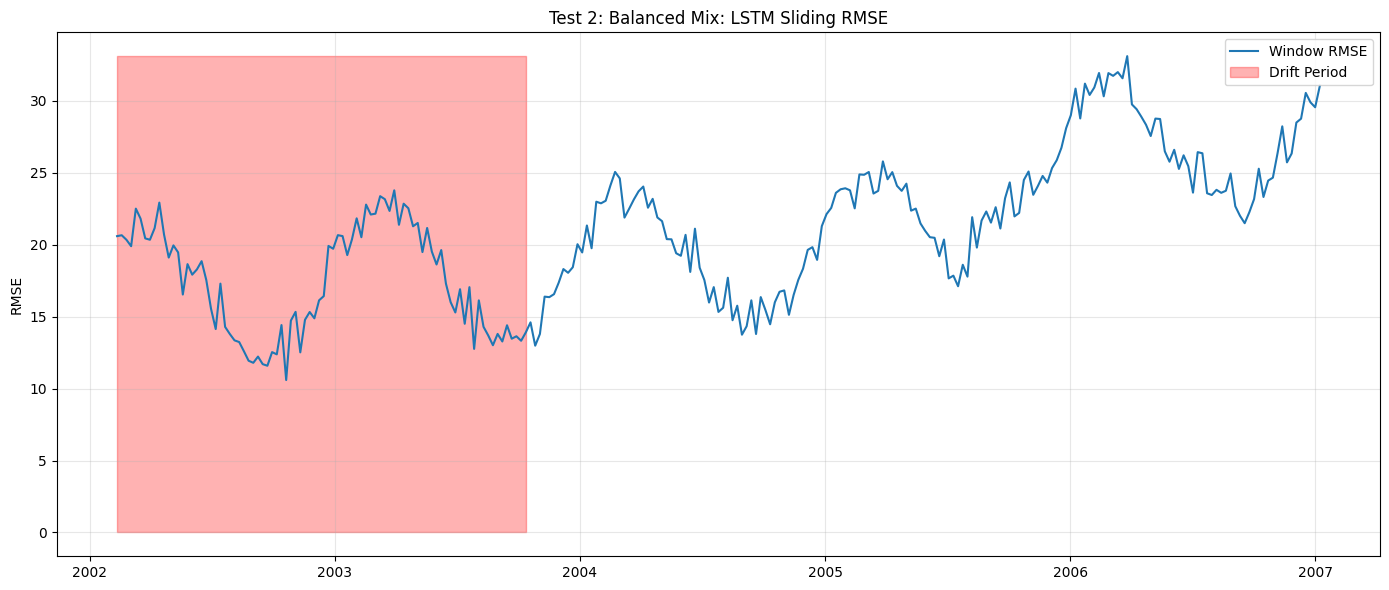

Stable RMSE: 22.703
Drift RMSE: 17.433
Robustness Ratio (Drift/Stable): 0.768

===== Test 3: Long Train, Short Inference =====


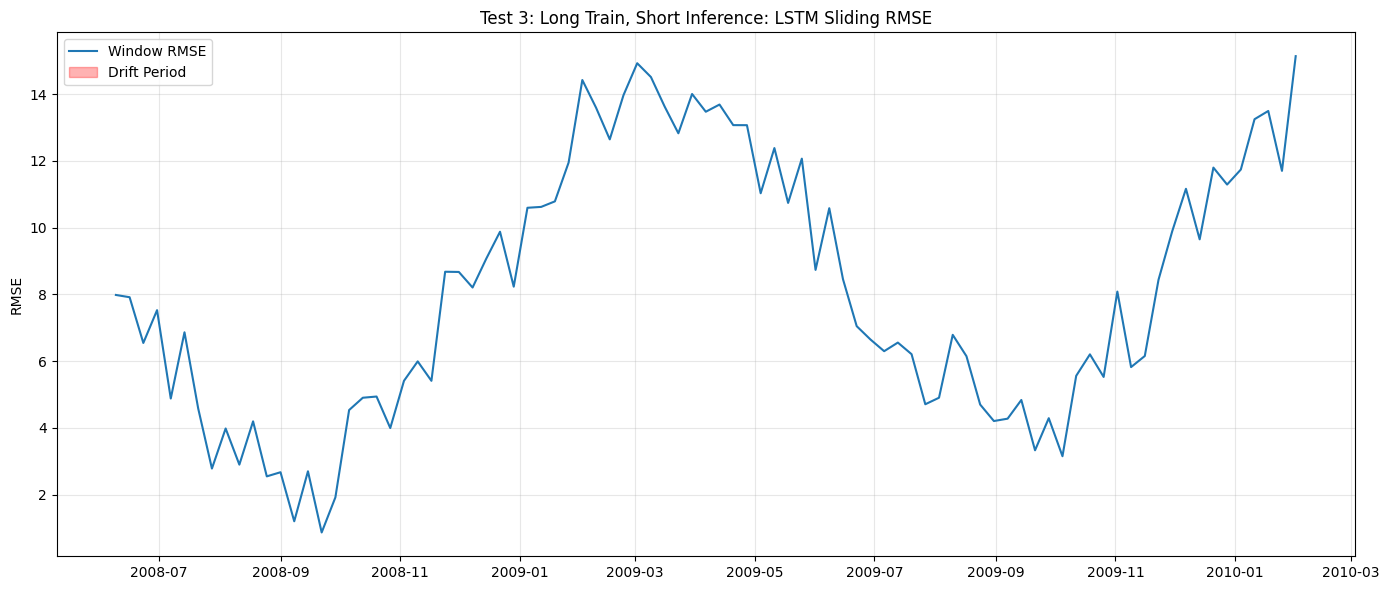

Stable RMSE: 8.100
Drift RMSE: 2.596
Robustness Ratio (Drift/Stable): 0.320

===== Test 4: Stable Only → Long Drift =====


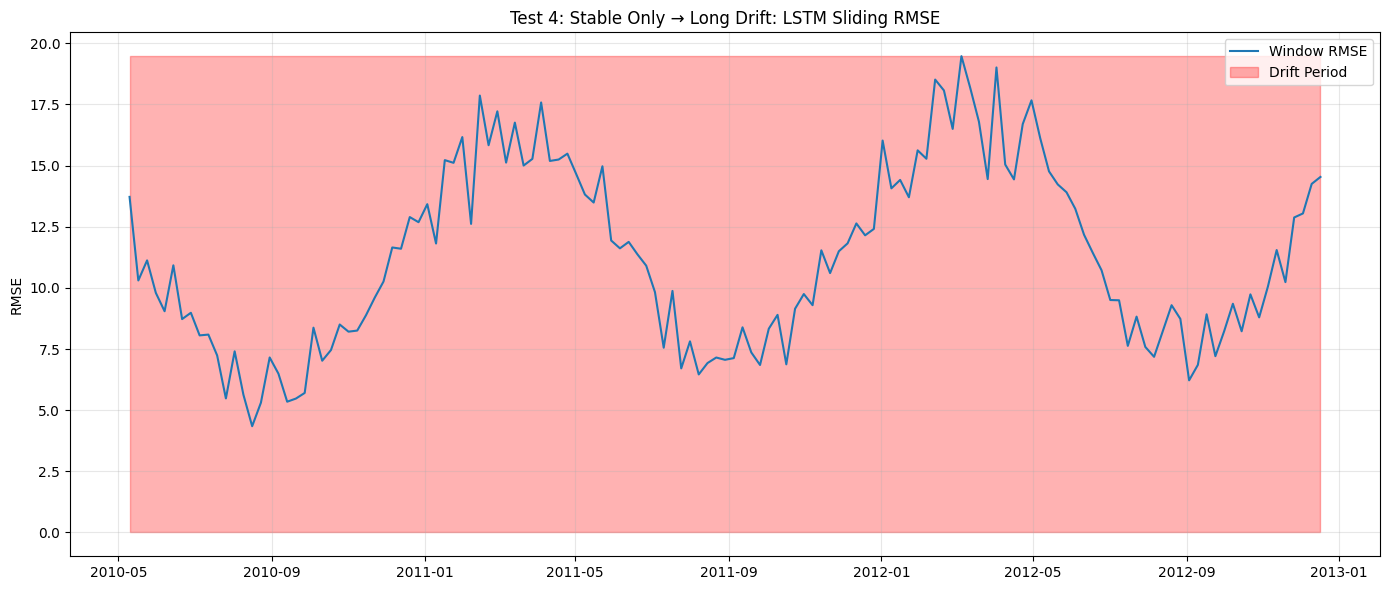

Stable RMSE: 0.879
Drift RMSE: 11.214
Robustness Ratio (Drift/Stable): 12.752

===== Test 5: Rolling Regimes =====


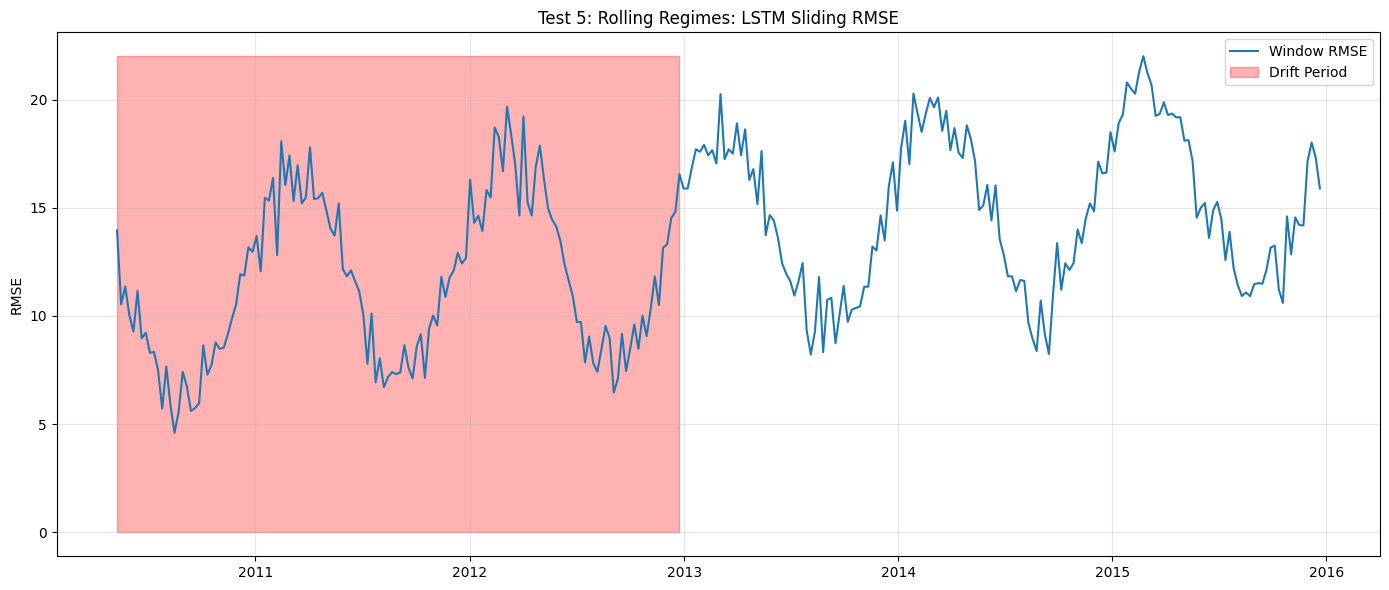

Stable RMSE: 14.964
Drift RMSE: 11.492
Robustness Ratio (Drift/Stable): 0.768


In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# === Load & Prepare Data ===
df = pd.read_csv('../Data/simulateddata.csv', parse_dates=['date'], index_col='date')
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['year'] = df.index.year
df['time_idx'] = np.arange(len(df))

for var in ['var1', 'var2', 'var3', 'var4', 'var5']:
    df[f'{var}_lag1'] = df[var].shift(1)
    df[f'{var}_lag2'] = df[var].shift(2)

df.dropna(inplace=True)

# === LSTM Model ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# === Sequence Prep ===
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# === Test Runner ===
def run_lstm_test(test_name, train_start, train_end, infer_start, infer_end):
    print(f"\n===== {test_name} =====")

    target = 'var1'
    features = [col for col in df.columns if col not in [target, 'drift_period']]
    scaler = StandardScaler()
    X_all = scaler.fit_transform(df[features])
    y_all = df[target].values
    df['scaled_idx'] = np.arange(len(df))

    train_mask = (df.index >= train_start) & (df.index <= train_end)
    infer_mask = (df.index >= infer_start) & (df.index <= infer_end)

    train_idx = df[train_mask]['scaled_idx'].astype(int).values
    infer_idx = df[infer_mask]['scaled_idx'].astype(int).values

    X_train = X_all[train_idx]
    y_train = y_all[train_idx]

    SEQ_LEN = 12
    X_seq_train, y_seq_train = create_sequences(X_train, y_train, SEQ_LEN)

    model = LSTMModel(X_seq_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_seq_train)
        loss = criterion(y_pred, y_seq_train)
        loss.backward()
        optimizer.step()

    # === Inference ===
    results = []
    for idx in range(infer_idx[0], infer_idx[-1] - SEQ_LEN):
        x_seq = torch.tensor(X_all[idx:idx+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
        y_true = y_all[idx + SEQ_LEN]
        y_pred = model(x_seq).item()
        rmse = np.sqrt((y_pred - y_true) ** 2)
        drift_flag = int(df.iloc[idx + SEQ_LEN]['drift_period'] > 0.5)
        date = df.index[idx + SEQ_LEN]
        results.append({'date': date, 'rmse': rmse, 'is_drift': drift_flag})

    results_df = pd.DataFrame(results).set_index('date')

    # === Compute RMSEs ===
    stable_rmse = results_df[results_df['is_drift'] == 0]['rmse'].mean()
    drift_rmse = results_df[results_df['is_drift'] == 1]['rmse'].mean()

    # === Fallback if either is missing ===
    if np.isnan(stable_rmse):
        stable_block = train_idx[df.iloc[train_idx]['drift_period'].values == 0]
        if len(stable_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[stable_block[0]:stable_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[stable_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            stable_rmse = np.sqrt((y_pred - y_true) ** 2)

    if np.isnan(drift_rmse):
        drift_block = train_idx[df.iloc[train_idx]['drift_period'].values == 1]
        if len(drift_block) >= SEQ_LEN + 1:
            x_test = torch.tensor(X_all[drift_block[0]:drift_block[0]+SEQ_LEN], dtype=torch.float32).unsqueeze(0)
            y_true = y_all[drift_block[0] + SEQ_LEN]
            y_pred = model(x_test).item()
            drift_rmse = np.sqrt((y_pred - y_true) ** 2)

    robustness_ratio = drift_rmse / stable_rmse if stable_rmse > 0 else float('nan')

    # === Plot ===
    plt.figure(figsize=(14, 6))
    plt.plot(results_df.index, results_df['rmse'], label='Window RMSE')
    plt.fill_between(results_df.index, 0, results_df['rmse'].max(),
                     where=results_df['is_drift'] == 1, color='red', alpha=0.3, label='Drift Period')
    plt.title(f'{test_name}: LSTM Sliding RMSE')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Stable RMSE: {stable_rmse:.3f}")
    print(f"Drift RMSE: {drift_rmse:.3f}")
    print(f"Robustness Ratio (Drift/Stable): {robustness_ratio:.3f}")

# === Run 5 Test Cases for LSTM ===

run_lstm_test("Test 1: Stable → Drift",
              "1990-01-01", "1994-10-10",       # stable block 1
              "1994-10-17", "1998-08-10")       # drift block 1

run_lstm_test("Test 2: Balanced Mix",
              "1994-10-17", "2001-11-12",       # drift block 1 + stable block 2
              "2001-11-19", "2007-01-15")       # drift block 2 + stable block 3

run_lstm_test("Test 3: Long Train, Short Inference",
              "1990-01-01", "2008-03-10",       # up to end of drift block 3
              "2008-03-17", "2010-02-08")       # stable block 4

run_lstm_test("Test 4: Stable Only → Long Drift",
              "1990-01-01", "2010-02-08",       # all stable blocks up to block 4
              "2010-02-15", "2012-12-24")       # drift block 4

run_lstm_test("Test 5: Rolling Regimes",
              "1990-01-01", "2010-02-08",       # mixed stable/drift train
              "2010-02-15", "2015-12-28")       # drift block 4 + stable block 5

